# Blog Post Clustering

My blog (https://www.mindcoolness.com) currently has 322 blog posts, which I have categorized into four broad groups. But wouldn't it be interesting to see how an unsupervised NLP model would cluster them? I think so, which is why I have written this notebook.

Overview:
1. Get Data
2. Vectorize Text
3. Analyze Clusters
4. Compare Predictions
5. Plot Results
6. Explore Clusters

Required modules: pandas, bs4, sklearn, matplotlib, mpld3

## 1. Get Data

Since I've already exported the blog post data from my MySQL sever in csv format, all I have to do here is load the csv file, filter the data, and extract the text from the html code.

In [1]:
import pandas as pd
from bs4 import BeautifulSoup

data = pd.read_csv('wp_posts.csv', sep=';')

data = data[(data['post_type'] == 'post') & (data['post_status'] == 'publish')]
data = data[['post_title', 'post_content']].reset_index(drop=True)

for i in data.index:
    soup = BeautifulSoup(data['post_content'].loc[i], 'html.parser')
    data['post_content'].loc[i] = soup.get_text()
    
data.tail()

,post_title,post_content
317,How the Brain Makes Emotions,Here's the latest state of the art in the cogn...
318,Is Willpower a Cognitive Strength?,\nWillpower is the ability to pursue long-term...
319,6 Reasons Why People Use Moral Language,"\nWhy do we use moral language?\nHello, I'm Do..."
320,The Bayesian Brain: Placebo Effects Explained,"\n\nIn my article on predictive processing, I ..."
321,"Great Minds Discuss Ideas, Great Men Also Disc...",\nOn great minds and great men\nGreat minds di...


## 2. Vectorize Text

Before I vectorize the post contents using frequency-inverse document frequency (tf-idf), I set some blog-specific stop words that would unduly distort my results.

In [2]:
from sklearn.feature_extraction import text
from sklearn.feature_extraction.text import TfidfVectorizer

stopwords = text.ENGLISH_STOP_WORDS.union(["note", "caption", "reading", "read", "true", "self", "mind",
                                           "don", "want", "people", "feel", "day"])

vectorizer = TfidfVectorizer(stop_words=stopwords, max_df=0.75, min_df=0.01)
tfidf_matrix = vectorizer.fit_transform(data['post_content'])

## 3. Analyze Clusters

I use KMeans to find four clusters in the vectorized blog posts and display the top three words of each cluster.

In [3]:
from sklearn.cluster import KMeans

model = KMeans(n_clusters=4, max_iter=200, n_init=2)
model.fit(tfidf_matrix)

centers = model.cluster_centers_.argsort()[:, ::-1]
words = vectorizer.get_feature_names()

top_words = {}
for i in range(4):
    top_words[i] = ""
    for c in centers[i, :3]:
        if top_words[i] == "":
            top_words[i] = words[c]
        else:
            top_words[i] = top_words[i] + ", " + words[c]
    print('Cluster %s:' %i, top_words[i])

Cluster 0: moral, freedom, values
Cluster 1: life, mindfulness, meditation
Cluster 2: pride, meaning, humility
Cluster 3: emotions, willpower, control


## 4. Compare Predictions

To find out the degree to which blog titles and contents belong to the same clusters, I predict in which cluster each title and content fits best and compute the overlap of these predictions. Moreover, I check how the four pairs of topic categories I use on my blog map to the four clusters computed here. 100% would mean that the model has categorized my blog posts very similarly to how I have categorized them.

In [4]:
title_predictions = []
content_predictions = []
for i in range(len(data['post_content'])):
    Titles = vectorizer.transform([data['post_title'][i]])
    title_predictions.append(model.predict(Titles))
    Contents = vectorizer.transform([data['post_content'][i]])
    content_predictions.append(model.predict(Contents))

match = []
for i in range(len(title_predictions)):
    if title_predictions[i] == content_predictions[i]:
        match.append(1)
    else:
        match.append(0)
print('Match:', sum(match)/len(match))

category_predictions = []
for cat in ('ethics politics', 'philosophy spirituality', 'psychology cognitive science', 'masculinity improvement'):
    Category = vectorizer.transform([cat])
    category_predictions.append(model.predict(Category)[0])  
print('Category similarity: ' + str(len(set(category_predictions))/4*100) + '%')

Match: 0.8074534161490683
Category similarity: 75.0%


## 5. Plot Results

As I want a two-dimensional plot, I must first apply multidimensional scaling to the cosine distance. Then I create a new data frame with coordinates, cluster labels, and post titles, which I group by the labels. Finally, I create a subplot for each cluster, save the figure as a png image, and display the plot.

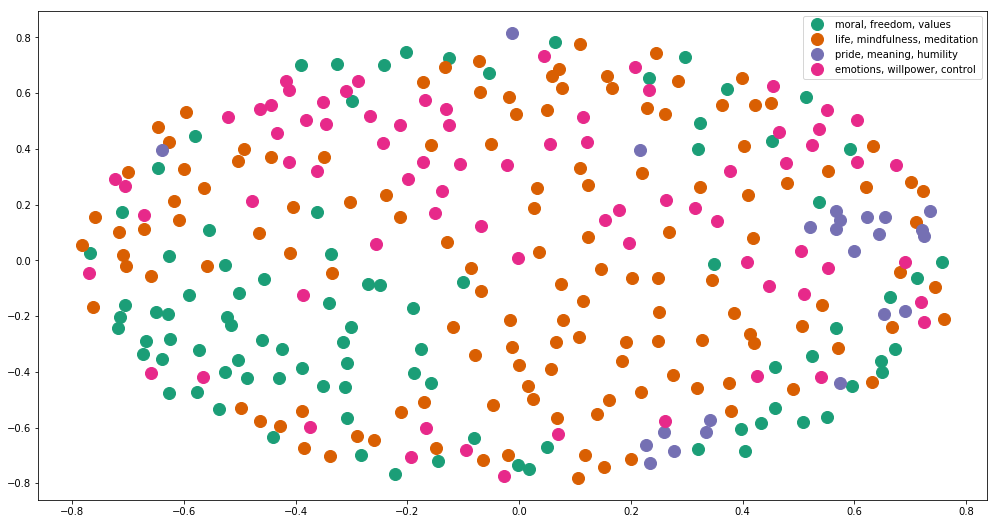

In [5]:
import matplotlib.pyplot as plt
from sklearn.manifold import MDS
from sklearn.metrics.pairwise import cosine_similarity
%matplotlib inline

dist = 1 - cosine_similarity(tfidf_matrix)
mds = MDS(n_components=2, dissimilarity="precomputed")
pos = mds.fit_transform(dist)
xs, ys = pos[:, 0], pos[:, 1]

df = pd.DataFrame(dict(x=xs, y=ys, label=model.labels_.tolist(), title=data['post_title']))
groups = df.groupby('label')

cluster_colors = {0: '#1b9e77', 1: '#d95f02', 2: '#7570b3', 3: '#e7298a'}
cluster_names = {0: top_words[0], 1: top_words[1], 2: top_words[2], 3: top_words[3]}

fig, ax = plt.subplots(figsize=(17, 9))
for c, g in groups: ax.plot(g.x, g.y, marker='o', linestyle='', ms=12, label=cluster_names[c], color=cluster_colors[c])  
ax.legend()

plt.savefig('clusters.png', dpi=200)
plt.show()

## 6. Explore Clusters

With the mpl3d package, I can use some JavaScript and CSS code to create an interactive map that shows a tooltip with the blog title for each data point when I hover over it. This is great for exploring how my blog posts were clustered. I must give credit here to Brandon Rose (http://brandonrose.org) for this awesome piece of code - thank you!

In [6]:
import mpld3

#define custom toolbar location
class TopToolbar(mpld3.plugins.PluginBase):
    """Plugin for moving toolbar to top of figure"""

    JAVASCRIPT = """
    mpld3.register_plugin("toptoolbar", TopToolbar);
    TopToolbar.prototype = Object.create(mpld3.Plugin.prototype);
    TopToolbar.prototype.constructor = TopToolbar;
    function TopToolbar(fig, props){
        mpld3.Plugin.call(this, fig, props);
    };

    TopToolbar.prototype.draw = function(){
      this.fig.toolbar.draw();
      this.fig.toolbar.toolbar.attr("x", 150);
      this.fig.toolbar.toolbar.attr("y", 400);
      this.fig.toolbar.draw = function() {}
    }
    """
    def __init__(self):
        self.dict_ = {"type": "toptoolbar"}


#define custom css to format the font and to remove the axis labeling
css = """
text.mpld3-text, div.mpld3-tooltip {
  font-family:Arial, Helvetica, sans-serif;
  font-size:14px;
  font-weight: bold;
  color: White;
  background-color: DodgerBlue;
}

g.mpld3-xaxis, g.mpld3-yaxis {
display: none; }

svg.mpld3-figure {
margin-left: -75px;}
"""

# create plot and layer it by iterating through groups
fig, ax = plt.subplots(figsize=(14,6))
for c, g in groups:
    points = ax.plot(g.x, g.y, marker='o', linestyle='', ms=18, label=cluster_names[c], color=cluster_colors[c])
    ax.set_aspect('auto')
    labels = [i for i in g.title]
    tooltip = mpld3.plugins.PointHTMLTooltip(points[0], labels, voffset=10, hoffset=10, css=css) # set tooltip
    mpld3.plugins.connect(fig, tooltip, TopToolbar()) # connect tooltip to fig
ax.legend(edgecolor='white')

html = mpld3.fig_to_html(fig)
with open("clusters.html", "w") as file: file.write(html)
mpld3.display()